In [1]:
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import dlib
import os
import random
import skimage
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from skimage.feature import local_binary_pattern
from skimage import feature
from sklearn.metrics import classification_report,accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
path = './dataset';

Preprocessing

In [2]:
#Input Parameters : filepath
#For a sequence file, returns a dictionary with each frame as its key and the object id, class and patch coordinates as the values
def parsefile(filepath):
    #  <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
    patch_mask = [False, True, True, False, False, False, True, True, True, True, False, False, False, False, False, False, False];
    lines = open(filepath, 'r').readlines();
    patch_dict = {};
    for line in lines:
        patch_data = line.strip().split(' ');
        patch_data = np.asarray(patch_data);
        frame = int(patch_data[0]);
        patch_data = patch_data[patch_mask];
        if (frame not in patch_dict.keys()):
            patch_dict[frame] = [];
            patch_dict[frame].append(patch_data);
        else:
            patch_dict[frame].append(patch_data);
    return patch_dict

In [3]:
#Patch dictionaries for each sequence containing the mask data`
patches_s0 = parsefile(path + '/0000.txt');
patches_s1 = parsefile(path + '/0001.txt');
patches_s2 = parsefile(path + '/0002.txt');
patches_s3 = parsefile(path + '/0003.txt');

In [4]:
#Input Parameters: The patch dictionary
#Returns a new dictionary with only the coordinates for the calculation of IoU
def processing_for_IoU(patch_dict):
    new_dict = {};
    for frame in patch_dict:
        patches_in_frame = patch_dict[frame];
        for patch in patches_in_frame:
            new_data = patch[2:];
            object_type = patch[1];
            if (object_type == 'Truck' or object_type == 'Van' or object_type == 'Car'):
                if (frame not in new_dict.keys()):
                    new_dict[frame] = [];
                    new_dict[frame].append(new_data);
                else:
                    new_dict[frame].append(new_data);
    return new_dict;

In [5]:
#Coordinates of each image patch for each sequence
patches_s0_IoU = processing_for_IoU(patches_s0);
patches_s1_IoU = processing_for_IoU(patches_s1);
patches_s2_IoU = processing_for_IoU(patches_s2);
patches_s3_IoU = processing_for_IoU(patches_s3);

In [ ]:
#Helper method if the directories for the patches do not exist
#for i in range(4):
#    dir_path = './dataset/Seq{}'.format(i);
#    os.mkdir(dir_path);

In [6]:
#Input Parameters: path of each sequence, path where the patches should be stored, dictionary of the patches
#Extracts the patches and saves them in the respective frame directory. Returns a list with all the labels present in the sequence
#For extracting the patches
def extract_patches(image_dir, sequence_patch_dir, patch_dict):
    i = 0;
    label_list = [];
    for frame_num in range(len(patch_dict)):
        patch_list = patch_dict[frame_num];
        if (frame_num < 10):
            img_path = image_dir + '00000{}.png'.format(frame_num);
        if (frame_num > 9 and frame_num < 100):
            img_path = image_dir + '0000{}.png'.format(frame_num);
        if (frame_num > 99):
            img_path = image_dir + '000{}.png'.format(frame_num);
        sequence_img = dlib.load_rgb_image(img_path);
        for patch in patch_list:
            label = (patch[0], patch[1]);
            patch_coordinates = patch[2:6];
            label_list.append((label, patch_coordinates));
            patch_rect = dlib.rectangle(int(float(patch_coordinates[0])), int(float(patch_coordinates[1])), int(float(patch_coordinates[2])), int(float(patch_coordinates[3])));
            img_patch = dlib.sub_image(sequence_img, patch_rect);
            save_file_path = sequence_patch_dir + 'img_{0}.jpeg'.format(i);
            dlib.save_image(img_patch, save_file_path);
            i = i + 1;
    return label_list;

In [7]:
s0 = path + '/0000/';
s1 = path + '/0001/';
s2 = path + '/0002/';
s3 = path + '/0003/';
output_dir_s0 = path + '/Seq0/';
output_dir_s1 = path + '/Seq1/';
output_dir_s2 = path + '/Seq2/';
output_dir_s3 = path + '/Seq3/';

In [8]:
#Extracts the image patches from the dataset directories
labels_s0 = extract_patches(s0, output_dir_s0, patches_s0);
labels_s1 = extract_patches(s1, output_dir_s1, patches_s1);
labels_s2 = extract_patches(s2, output_dir_s2, patches_s2);
labels_s3 = extract_patches(s3, output_dir_s3, patches_s3);

In [9]:
#Input Parameters: The directory of the patches, labels for the patches
#Splits the dataset into their respective lists
#The alternate datapoints for non_vehicle_min_overlap are in comments
def dataset_split(sequence_patch_dir, labels):
    dont_cares = [];
    trucks = [];
    vans = [];
    cars = [];
    cyclists = [];
    pedestrians = [];
    miscellaneous = [];
    vehicle_coordinates = [];
    for index, datapoint in enumerate(labels):
        label, coordinates = datapoint;
        image_path = sequence_patch_dir + 'img_' + str(index) + '.jpeg';
        image = dlib.load_rgb_image(image_path);
        np.asarray(image).astype(np.float32);
        if (label[1] == 'DontCare'):
            datapoint = (image, label[1]);
            #dont_cares.append((datapoint, coordinates));
            dont_cares.append(datapoint);
        elif (label[1] == 'Truck'):
            datapoint = (image, label[1]);
            #trucks.append((datapoint, coordinates));
            trucks.append(datapoint);
            vehicle_coordinates.append(coordinates);
        elif (label[1] == 'Van'):
            datapoint = (image, label[1]);
            #vans.append((datapoint, coordinates));
            vans.append(datapoint);
            vehicle_coordinates.append(coordinates);
        elif (label[1] == 'Car'):
            datapoint = (image, label[1]);
            #cars.append((datapoint, coordinates));
            cars.append(datapoint);
            vehicle_coordinates.append(coordinates);
        elif (label[1] == 'Cyclist'):
            datapoint = (image, label[1]);
            #cyclists.append((datapoint, coordinates));
            cyclists.append(datapoint);
        elif (label[1] == 'Pedestrian'):
            datapoint = (image, label[1]);
            #pedestrians.append((datapoint, coordinates));
            pedestrians.append(datapoint);
        elif (label[1] == 'Misc'):
            datapoint = (image, label[1]);
            #miscellaneous.append((datapoint, coordinates));
            miscellaneous.append(datapoint);
        else:
            print(label[1])
    return dont_cares, trucks, vans, cars, cyclists, pedestrians, miscellaneous, vehicle_coordinates;

In [10]:
#The entire dataset - Contains a tuple of the image and the label, and the coordinates of the vehicle patches
dont_cares_s0, trucks_s0, vans_s0, cars_s0, cyclists_s0, pedestrians_s0, miscellaneous_s0, vehicle_coords_s0 = dataset_split(output_dir_s0, labels_s0);
dont_cares_s1, trucks_s1, vans_s1, cars_s1, cyclists_s1, pedestrians_s1, miscellaneous_s1, vehicle_coords_s1 = dataset_split(output_dir_s1, labels_s1);
dont_cares_s2, trucks_s2, vans_s2, cars_s2, cyclists_s2, pedestrians_s2, miscellaneous_s2, vehicle_coords_s2 = dataset_split(output_dir_s2, labels_s2);
dont_cares_s3, trucks_s3, vans_s3, cars_s3, cyclists_s3, pedestrians_s3, miscellaneous_s3, vehicle_coords_s3 = dataset_split(output_dir_s3, labels_s3);

In [14]:
#Attempted to separate non vehicles with overlap, method doesn't work
#(left, top, right, bottom)
def extract_non_vehicles_min_overlap(non_vehicle_dataset, vehicle_coords):
    reduced_non_vehicles = [];
    for datapoint, coordinates in non_vehicle_dataset:
        nv_x1, nv_y1, nv_x3, nv_y3 = coordinates.astype(float);
        nv_x2 = nv_x3;
        nv_y2 = nv_y1;
        nv_x4 = nv_x1;
        nv_y4 = nv_y3;
        overlap_exists = False;
        for vehicle_coordinate in vehicle_coords:
            v_x1, v_y1, v_x3, v_y3 = vehicle_coordinate.astype(float);
            v_x2 = v_x3;
            v_y2 = v_y1;
            v_x4 = v_x1;
            v_y4 = v_y3;
            if ((nv_x1 < v_x3) and (nv_x1 > v_x4) and (nv_y1 > v_y3) and (nv_y1 < v_y2)):
                area = (v_x3 - nv_x1) * (v_y3 - nv_y1);
                if (area > 25):
                    overlap_exists = True;
            elif ((nv_x2 > v_x4) and (nv_x2 < v_x3) and (nv_y2 > v_y4) and (nv_y2 < v_y1)):
                area = (nv_x2 - v_x4) * (v_y4 - nv_y2);
                if (area > 25):
                    overlap_exists = True;
            elif ((nv_x3 > v_x1) and (nv_x3 < nv_x2) and (nv_y3 > v_y1) and (nv_y1 < nv_y4)):
                area = (nv_x3 - v_x1) * (nv_y3 - v_y1);
                if (area > 25):
                    overlap_exists = True;
            elif ((nv_x4 > v_x1) and (nv_x4 < nv_x2) and (nv_y4 > v_y1) and (nv_y4 < v_y4)):
                area = (v_x3 - nv_x4) * (nv_y4 - v_y1);
                if (area > 25):
                    overlap_exists = True;
            else:
                continue;
        if (overlap_exists == False):
            reduced_non_vehicles.append((datapoint, coordinates));
    return reduced_non_vehicles;

In [11]:
#Classes combined
dont_cares = dont_cares_s0 + dont_cares_s1 + dont_cares_s2 + dont_cares_s3;
trucks = trucks_s0 + trucks_s1 + trucks_s2 + trucks_s3;
vans = vans_s0 + vans_s1 + vans_s2 + vans_s3;
cars = cars_s0 + cars_s1 + cars_s2 + cars_s3;
cyclists = cyclists_s0 + cyclists_s1 + cyclists_s2 + cyclists_s3;
pedestrians = pedestrians_s0 + pedestrians_s1 + pedestrians_s2 + pedestrians_s3;
miscellaneous = miscellaneous_s0 + miscellaneous_s1 + miscellaneous_s2 + miscellaneous_s3;

In [52]:
#Counts of each class
print(len(dont_cares_count));
print(len(trucks_count))
print(len(vans_count));
print(len(cars_count));
print(len(cyclists_count));
print(len(pedestrians_count));
print(len(miscellaneous_count));

2540
114
565
4020
229
251
36


In [15]:
#Total count of each class
vehicle_count = trucks_count + vans_count + cars_count;
non_vehicle_count = cyclists_count + dont_cares_count + pedestrians_count + miscellaneous_count;

NameError: name 'trucks_count' is not defined

In [41]:
print(vehicle_count);
print(non_vehicle_count);

4699
3056


In [42]:
#Input Parameter: list to find the aspect ratio for
#Returns the average aspect ratio
def average_aspect_ratio(data_list):
    aspect_ratio_list = [];
    for item in data_list:
        image , _ = item;
        image_aspect_ratio = np.asarray(image.shape)
        aspect_ratio_list.append(image_aspect_ratio);
    aspect_ratio_array = np.vstack(aspect_ratio_list);
    average_aspect_ratio = aspect_ratio_array.mean(0);
    return average_aspect_ratio;

In [53]:
#Average aspect ratios for each class in each sequence
dont_cares_aspect_ratio = average_aspect_ratio(dont_cares);
trucks_aspect_ratio = average_aspect_ratio(trucks);
vans_aspect_ratio = average_aspect_ratio(vans);
cars_aspect_ratio = average_aspect_ratio(cars);
cyclist_aspect_ratio = average_aspect_ratio(cyclists);
pedestrians_aspect_ratio = average_aspect_ratio(pedestrians);
miscellaneous_aspect_ratio = average_aspect_ratio(miscellaneous);

In [54]:
#Average aspect ratios for each class in each sequence
print(dont_cares_aspect_ratio);
print(trucks_aspect_ratio);
print(vans_aspect_ratio);
print(cars_aspect_ratio);
print(cyclist_aspect_ratio);
print(pedestrians_aspect_ratio);
print(miscellaneous_aspect_ratio);

[35.92637795 62.95669291  3.        ]
[ 72.15789474 191.06140351   3.        ]
[ 84.3699115  126.11150442   3.        ]
[ 67.17462687 114.82935323   3.        ]
[132.4279476  103.78165939   3.        ]
[87.90438247 32.30677291  3.        ]
[60.05555556 97.86111111  3.        ]


In [55]:
#Input Parameters: list of images where the datapoints are the image themselves and the labels
#Method to find the min aspect ratio for each class
def find_min_aspect_ratio(images):
    min_image , _ = images[0];
    current_min = min_image.shape[0] + min_image.shape[1];
    for image, _ in images[1:]:
        image_min = image.shape[0] + image.shape[1];
        if image_min < current_min:
            current_min = image_min;
            min_image = image;
    min_aspect_ratio = min_image.shape;
    return min_aspect_ratio;

In [56]:
#The minimum shape of each class for the purpose of determining the feature window
dont_cares_min_shape = find_min_aspect_ratio(dont_cares);
trucks_min_shape = find_min_aspect_ratio(trucks);
vans_min_shape = find_min_aspect_ratio(vans);
cars_min_shape = find_min_aspect_ratio(cars);
cyclists_min_shape = find_min_aspect_ratio(cyclists);
pedestrians_min_shape = find_min_aspect_ratio(pedestrians);
miscellaneous_min_shape = find_min_aspect_ratio(miscellaneous);

In [57]:
print(dont_cares_min_shape)
print(trucks_min_shape)
print(vans_min_shape)
print(cars_min_shape)
print(cyclists_min_shape)
print(pedestrians_min_shape)
print(miscellaneous_min_shape)

(8, 11, 3)
(38, 73, 3)
(25, 28, 3)
(14, 19, 3)
(33, 42, 3)
(21, 8, 3)
(28, 51, 3)


In [12]:
#Input Parameters: list of images where the datapoints are the image themselves and the labels
#Rescales the image patches to 85x85
def rescale(images):
    rescaled_images = [];
    for datapoint in images:
        image, label = datapoint;
        rescaled_image = dlib.resize_image(image, 85, 85);
        rescaled_images.append((rescaled_image, label));
    return rescaled_images;

In [13]:
#Each class rescaled
dont_cares_rescaled = rescale(dont_cares);
trucks_rescaled = rescale(trucks);
vans_rescaled = rescale(vans);
cars_rescaled = rescale(cars);
cyclists_rescaled = rescale(cyclists);
pedestrians_rescaled = rescale(pedestrians);
miscellaneous_rescaled = rescale(miscellaneous);

In [15]:
#Input Parameters: list of images where the datapoints are the image themselves and the labels
#Converts the image patches to grayscale
def convert_to_gray(images):
    grayscale_images = [];
    for image, label in images:
        gray_image = dlib.as_grayscale(image);
        grayscale_images.append((gray_image, label));
    return grayscale_images;

In [16]:
#Each class in grayscale
dont_cares_grayscale = convert_to_gray(dont_cares_rescaled);
trucks_grayscale = convert_to_gray(trucks_rescaled);
vans_grayscale = convert_to_gray(vans_rescaled);
cars_grayscale = convert_to_gray(cars_rescaled);
cyclists_grayscale = convert_to_gray(cyclists_rescaled);
pedestrians_grayscale = convert_to_gray(pedestrians_rescaled);
miscellaneous_grayscale = convert_to_gray(miscellaneous_rescaled);

In [1924]:
#Constructor for dataset object
class classifier_dataset:
    def __init__(self, dataset):
        self.datapoints = [];
        self.targets = [];
        for image, label in dataset:
            self.datapoints.append(image);
            self.targets.append(label);

In [1962]:
#Creates three partitions of the data and labels
def partition(dataset, labels):
    partition_1_images = [];
    partition_1_labels = [];
    partition_2_images = [];
    partition_2_labels = [];
    partition_3_images = [];
    partition_3_labels = [];
    partition_1 = True;
    partition_2 = False;
    partition_3 = False;
    c = 0;
    for datapoint in zip(dataset,labels):
        image, label = datapoint;
        c = c+ 1;
        if (partition_1 == True):
            partition_1_images.append(image);
            partition_1_labels.append(label);
            partition_1 = False;
            partition_2 = True;
        elif (partition_2 == True):
            partition_2_images.append(image);
            partition_2_labels.append(label);
            partition_2 = False;
            partition_3 = True;
        elif (partition_3 == True):
            partition_3_images.append(image);
            partition_3_labels.append(label);
            partition_3 = False;
            partition_1 = True;
    return partition_1_images, partition_1_labels, partition_2_images, partition_2_labels, partition_3_images, partition_3_labels;

In [17]:
#Returns a matrix with 1d feature vectors as rows
def flatten(*args):
    flattened_set = [];
    for arg in args:
        for image in arg:
            flattened_image = image.flatten();
            flattened_set.append(flattened_image);
    features = np.stack(flattened_set, axis=0);
    return features;

In [960]:
#labels = ['DontCare', 'Truck', 'Van', 'Car', 'Cyclist', 'Pedestrian', 'Misc'];
def precision_and_recall(predictions, targets):
    dont_care_tp, dont_care_fp, dont_care_fn = 0, 0, 0;
    truck_tp, truck_fp, truck_fn = 0, 0, 0;
    van_tp, van_fp, van_fn = 0, 0, 0;
    car_tp, car_fp, car_fn = 0, 0, 0;
    cyclist_tp, cyclist_fp, cyclist_fn = 0, 0, 0;
    pedestrian_tp, pedestrian_fp, pedestrian_fn = 0, 0, 0;
    miscellaneous_tp, miscellaneous_fp, miscellaneous_fn = 0, 0, 0;
    for i in range(len(predictions)):
        prediction = predictions[i];
        actual = targets[i];
        correct_pred = (prediction == actual);
        if (prediction == 'DontCare'):
            if (correct_pred == True):
                dont_care_tp += 1;
            else:
                dont_care_fp += 1;
                if (actual == 'Truck'):
                    truck_fn += 1;
                elif (actual == 'Van'):
                    van_fn += 1;
                elif (actual == 'Car'):
                    car_fn += 1;
                elif (actual == 'Cyclist'):
                    cyclist_fn += 1;
                elif (actual == 'Pedestrian'):
                    pedestrian_fn += 1;
                elif (actual == 'Misc'):
                    miscellaneous_fn += 1;
        elif (prediction == 'Truck'):
            if (correct_pred == True):
                truck_tp += 1;
            else:
                truck_fp += 1;
                if (actual == 'DontCare'):
                    dont_care_fn += 1;
                elif (actual == 'Van'):
                    van_fn += 1;
                elif (actual == 'Car'):
                    car_fn += 1;
                elif (actual == 'Cyclist'):
                    cyclist_fn += 1;
                elif (actual == 'Pedestrian'):
                    pedestrian_fn += 1;
                elif (actual == 'Misc'):
                    miscellaneous_fn += 1;
        elif (prediction == 'Van'):
            if (correct_pred == True):
                van_tp += 1;
            else:
                van_fp += 1;
                if (actual == 'DontCare'):
                    dont_care_fn += 1;
                elif (actual == 'Truck'):
                    truck_fn += 1;
                elif (actual == 'Car'):
                    car_fn += 1;
                elif (actual == 'Cyclist'):
                    cyclist_fn += 1;
                elif (actual == 'Pedestrian'):
                    pedestrian_fn += 1;
                elif (actual == 'Misc'):
                    miscellaneous += 1;
        elif (prediction == 'Car'):
            if (correct_pred == True):
                car_tp += 1;
            else:
                car_fp += 1;
                if (actual == 'DontCare'):
                    dont_care_fn += 1;
                elif (actual == 'Truck'):
                    truck_fn += 1;
                elif (actual == 'Van'):
                    van_fn += 1;
                elif (actual == 'Cyclist'):
                    cyclist_fn += 1;
                elif (actual == 'Pedestrian'):
                    pedestrian_fn += 1;
                elif (actual == 'Misc'):
                    miscellaneous_fn += 1;                
        elif (prediction == 'Cyclist'):
            if (correct_pred == True):
                cyclist_tp += 1;
            else:
                cyclist_fp += 1;
                if (actual == 'DontCare'):
                    dont_care_fn += 1;
                elif (actual == 'Truck'):
                    truck_fn += 1;
                elif (actual == 'Van'):
                    van_fn += 1;
                elif (actual == 'Car'):
                    car_fn += 1;
                elif (actual == 'Pedestrian'):
                    pedestrian_fn += 1;
                elif (actual == 'Misc'):
                    miscellaneous_fn += 1; 
        elif (prediction == 'Pedestrian'):
            if (correct_pred == True):
                pedestrian_tp += 1;
            else:
                pedestrian_fp += 1;
                if (actual == 'DontCare'):
                    dont_care_fn += 1;
                elif (actual == 'Truck'):
                    truck_fn += 1;
                elif (actual == 'Van'):
                    van_fn += 1;
                elif (actual == 'Car'):
                    car_fn += 1;
                elif (actual == 'Cyclist'):
                    cyclist_fn += 1;
                elif (actual == 'Misc'):
                    miscellaneous_fn += 1;                 
        elif (prediction == 'Misc'):
            if (correct_pred == True):
                miscellaneous_tp += 1;
            else:
                miscellaneous_fp += 1;
                if (actual == 'DontCare'):
                    dont_care_fn += 1;
                elif (actual == 'Truck'):
                    truck_fn += 1;
                elif (actual == 'Van'):
                    van_fn += 1;
                elif (actual == 'Car'):
                    car_fn += 1;
                elif (actual == 'Cyclist'):
                    cyclist_fn += 1;
                elif (actual == 'Pedestrian'):
                    pedestrian_fn += 1;                  
    dont_care_prec = dont_care_tp / (dont_care_tp + dont_care_fp);
    dont_care_rec = dont_care_tp / (dont_care_tp + dont_care_fn);
    truck_prec = truck_tp / (truck_tp + truck_fp);
    truck_rec = truck_tp / (truck_tp + truck_fn);
    van_prec = van_tp / (van_tp + van_fp);
    van_rec = van_tp / (van_tp + van_fn);
    car_prec = car_tp / (car_tp + car_fp);
    car_rec = car_tp / (car_tp + car_fn);
    cyclist_prec = cyclist_tp / (cyclist_tp + cyclist_fp);
    cyclist_rec = cyclist_tp / (cyclist_tp + cyclist_fn);
    pedestrian_prec = pedestrian_tp / (pedestrian_tp + pedestrian_fp);
    pedestrian_rec = pedestrian_tp / (pedestrian_tp + pedestrian_fn);
    miscellaneous_prec = miscellaneous_tp / (miscellaneous_tp + miscellaneous_fp);
    miscellaneous_rec = miscellaneous_tp / (miscellaneous_tp + miscellaneous_fn);
    return dont_care_prec, dont_care_rec, truck_prec, truck_rec, van_prec, van_rec, car_prec, car_rec, cyclist_prec, cyclist_rec, pedestrian_prec, pedestrian_rec, miscellaneous_prec, miscellaneous_rec;

In [18]:
#Helper method to extract only the images for binary classification
def extract_images(dataset):
    images = [];
    for image in dataset:
        image_data, _ = image;
        images.append(image_data);
    return images;

In [19]:
dont_cares_gs = extract_images(dont_cares_grayscale); 
trucks_gs = extract_images(trucks_grayscale);
vans_gs = extract_images(vans_grayscale);
cars_gs = extract_images(cars_grayscale);
cyclists_gs = extract_images(cyclists_grayscale);
pedestrians_gs = extract_images(pedestrians_grayscale);
miscellaneous_gs = extract_images(miscellaneous_grayscale);

In [20]:
#The dataset combined for the purpose of training the classifier
vehicles_gs = trucks_gs + vans_gs + cars_gs;
non_vehicles_gs = dont_cares_gs + cyclists_gs + pedestrians_gs + miscellaneous_gs;
images_combined_gs = vehicles_gs + non_vehicles_gs;
gs_comb_flattened = flatten(images_combined_gs);

#Label generation
# 1 is vehicle
# 0 is non-vehicle
vehicles_labels = [];
non_vehicles_labels = [];
for i in range(len(vehicles_gs)):
  vehicles_labels.append(1)
for j in range(len(non_vehicles_gs)):
  non_vehicles_labels.append(0)
labels_combined = vehicles_labels + non_vehicles_labels;

In [2270]:
# RBF SVM Classifier
scoring = ['accuracy','precision','recall'];
clf_rbf_gs = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
scores_svm = cross_validate(clf_rbf_gs, gs_comb_flattened, labels_combined, scoring=scoring, cv=3);
sorted(scores_svm.keys());
print(scores_svm);

{'fit_time': array([49.75358391, 46.10083699, 44.70000672]), 'score_time': array([37.62413502, 32.59647703, 29.8294661 ]), 'test_accuracy': array([0.7655706 , 0.76518375, 0.71644101]), 'test_precision': array([0.80163214, 0.82376772, 0.80783444]), 'test_recall': array([0.81493299, 0.77905492, 0.69795658])}


In [21]:
#Input Parameters: ndarray with the each image point as a row
#Returns a decorrelated matrix and the rotation matrix used to achieve the decorrelation
def whiten_images_combined(images):
    flattened_images = [];
    decorrelated_images = [];
    for image in images:
        flattened_image = image.flatten();
        flattened_images.append((flattened_image));
    features = np.stack(flattened_images, axis = 1);
    features_mean = features.mean(axis=1);
    features_mean = features_mean.reshape((features_mean.shape[0], 1));
    features_centered = features - features_mean;
    features_centered_t = np.transpose(features_centered);
    covariance_matrix = (1/(features_centered.shape[1]-1)) * np.matmul(features_centered, features_centered_t);
    _ , egnvec = np.linalg.eig(covariance_matrix);
    egnvec = np.real(egnvec);
    rotation_matrix = np.stack(egnvec, axis = 1);
    rotation_matrix_t = np.transpose(rotation_matrix);
    for flattened_image in flattened_images:
        flattened_image_t = np.transpose(flattened_image);
        decorrelated_image = np.matmul(rotation_matrix_t, flattened_image_t).reshape((85,85));
        decorrelated_images.append(decorrelated_image);
    return decorrelated_images, rotation_matrix_t;

In [26]:
#Decorrelated image patches using the whitening procedure
images_combined_wh, bin_rotation_matrix = whiten_images_combined(images_combined_gs);

In [22]:
gs_shuffled, labels_shuffled_gs = shuffle(images_combined_gs, labels_combined);
#wh_shuffled, labels_shuffled_wh = shuffle(images_combined_wh, labels_combined);

In [24]:
# SVM
# https://www.kaggle.com/code/manikg/training-svm-classifier-with-hog-features/notebook
img_size = (85, 85); # h x w in pixels
cell_size = (6, 6);  # h x w in pixels
block_size = (6, 6);  # h x w in cells
nbins = 8;  # number of orientation bins

# create HoG Object
# winSize is the size of the image cropped to multiple of the cell size
# all arguments should be given in terms of number of pixels
hog = cv.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins);

In [25]:
#Extraction of the HOG Feature Descriptors
hog_feature_gs = [];
for i in range(len(images_combined_gs)):
    hog_feature_gs.append(hog.compute(gs_shuffled[i].astype(np.uint8)).reshape(1, -1));
hog_features_gs = np.vstack(hog_feature_gs);

#hog_feature_wh = [];
#for i in range(len(images_combined_wh)):
#    hog_feature_wh.append(hog.compute(wh_shuffled[i].astype(np.uint8)).reshape(1, -1));
#hog_features_wh = np.vstack(hog_feature_wh);

In [26]:
#Extraction of the LBP Feature Descriptors
lbp_feature_gs = [];
for i in range(len(images_combined_gs)):
    lbp_feature_gs.append(local_binary_pattern(gs_shuffled[i].astype(np.uint8), 8, 1, method='uniform').reshape(1, -1));
lbp_features_gs = np.vstack(lbp_feature_gs);

#lbp_feature_wh = [];
#for i in range(len(images_combined_wh)):
#    lbp_feature_wh.append(local_binary_pattern(wh_shuffled[i].astype(np.uint8), 8, 1, method='uniform').reshape(1, -1));
#lbp_features_wh = np.vstack(lbp_feature_wh);

In [27]:
#Declaration of the Classifiers
clf_rbf_hog_gs = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
#clf_rbf_hog_wh = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
clf_forest_hog_gs = RandomForestClassifier(n_estimators=300, max_depth=10, criterion='entropy');
clf_rbf_lbp_gs = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
#clf_rbf_lbp_wh = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);

In [ ]:
# RBF SVM Classifier
scoring = ['accuracy','precision','recall'];
clf_rbf_hog_gs = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
scores_svm = cross_validate(clf_rbf_hog_gs, hog_features_gs, labels_shuffled_gs, scoring=scoring, cv=3);
sorted(scores_svm.keys());
print(scores_svm);

In [88]:
# RBF SVM Classifier
clf_rbf_hog_wh = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
scores_svm = cross_validate(clf_rbf_hog_wh, hog_features_wh, labels_shuffled_wh, scoring=scoring, cv=3);
sorted(scores_svm.keys());
print(scores_svm);

{'fit_time': array([195.8293438 , 195.55673313, 193.45933604]), 'score_time': array([209.71248698, 203.21927309, 197.76522684]), 'test_accuracy': array([0.79729207, 0.7926499 , 0.78491296]), 'test_precision': array([0.81510574, 0.80509479, 0.80239521]), 'test_recall': array([0.86088066, 0.86781609, 0.85568327])}


In [91]:
# RBF SVM Classifier
clf_rbf_lbp_gs = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
scores_svm = cross_validate(clf_rbf_lbp_gs, lbp_features_gs, labels_shuffled_gs, scoring=scoring, cv=3);
sorted(scores_svm.keys());
print(scores_svm);

{'fit_time': array([113.80971599, 111.57283092, 111.01863313]), 'score_time': array([73.81787896, 74.30117416, 74.5572021 ]), 'test_accuracy': array([0.7934236 , 0.80309478, 0.80425532]), 'test_precision': array([0.79907354, 0.80637681, 0.80320366]), 'test_recall': array([0.88066369, 0.88825032, 0.89655172])}


In [95]:
# RBF SVM Classifier
clf_rbf_lbp_wh = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
scores_svm = cross_validate(clf_rbf_lbp_wh, lbp_features_wh, labels_shuffled_wh, scoring=scoring, cv=3);
sorted(scores_svm.keys());
print(scores_svm);

{'fit_time': array([109.55532002, 106.310004  , 108.71103525]), 'score_time': array([70.01437712, 69.9885869 , 70.38083482]), 'test_accuracy': array([0.88355899, 0.88433269, 0.88626692]), 'test_precision': array([0.8813253 , 0.87730792, 0.88267148]), 'test_recall': array([0.93363114, 0.94061303, 0.93678161])}


In [100]:
# Random Forest Classifier
scoring = ['accuracy','precision','recall'];
clf_forest_hog_gs = RandomForestClassifier(n_estimators=300, max_depth=10, criterion='entropy');
scores_forest = cross_validate(clf_forest_hog_gs, hog_features_gs, labels_shuffled_gs, scoring=scoring, cv=3);
sorted(scores_forest.keys());
print(scores_forest);

{'fit_time': array([150.21326613, 141.85306787, 139.55206203]), 'score_time': array([0.62018394, 0.29228616, 0.27108192]), 'test_accuracy': array([0.89439072, 0.90019342, 0.89168279]), 'test_precision': array([0.90897598, 0.91444867, 0.90955414]), 'test_recall': array([0.91767709, 0.92145594, 0.91187739])}


In [28]:
clf_rbf_hog_gs.fit(hog_features_gs, labels_shuffled_gs);
#clf_rbf_hog_wh.fit(hog_features_wh, labels_shuffled_wh);
clf_rbf_lbp_gs.fit(lbp_features_gs, labels_shuffled_gs);
#clf_rbf_lbp_wh.fit(lbp_features_wh, labels_shuffled_wh);
clf_forest_hog_gs.fit(hog_features_gs, labels_shuffled_gs);

In [ ]:
binary_classifiers = [clf_rbf_hog_gs, clf_forest_hog_gs, clf_rbf_hog_wh, clf_rbf_lbp_gs, clf_rbf_lbp_wh];

In [ ]:
binary_classifiers = [clf_rbf_hog_gs, clf_forest_hog_gs, clf_rbf_lbp_gs];

In [40]:
#Original vehicle detector
def vehicle_detector(image, classifiers, rotation_matrix):
    img_size = (85, 85); # h x w in pixels
    cell_size = (6, 6);  # h x w in pixels
    block_size = (6, 6);  # h x w in cells
    nbins = 8;  # number of orientation bins
    hog = cv.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins);
    height, width = image.shape;
    located_vehicles = [];
    for i in range(0, height, 25):
        for j in range(0, width, 25):
            window = image[i:i+85,j:j+85];
            if (window.shape[0] == 85 and window.shape[1] == 85):
                window_hog_feature = hog.compute(window.reshape(85,85));
                window_lbp_feature = local_binary_pattern(window, 8, 1, method='uniform').reshape(1, -1);
                pred_count = 0;
                for index, classifier in enumerate(classifiers):
                    if (index < 2):
                        pred_count += classifier.predict(window_hog_feature.reshape(1,-1));
                    if (index == 2):
                        pred_count += classifier.predict(window_lbp_feature);
                if (pred_count > 2):
                    located_vehicles.append((i,j));
    rects = [];
    for rect_coord in located_vehicles:
        y, x = rect_coord;
        rect = (x , y, x+140, y +75);
        rects.append(rect);
    min_rect, _ = cv.groupRectangles(rects, 4);
    for bb in min_rect:
        l, t, r, b = bb[0], bb[1], bb[2], bb[3];
        image_bb = cv.rectangle(image, (l,t), (r, b), (255,0,0), 2);
    return image_bb, min_rect;

In [76]:
test_image1 = dlib.as_grayscale(dlib.load_rgb_image(s0 + '000000.png'));
test_image2 = dlib.as_grayscale(dlib.load_rgb_image(s0 + '000134.png'));
test_image3 = dlib.as_grayscale(dlib.load_rgb_image(s1 + '000253.png'));
test_image4 = dlib.as_grayscale(dlib.load_rgb_image(s3 + '000039.png'));
test_image5 = dlib.as_grayscale(dlib.load_rgb_image(s2 + '000135.png'));

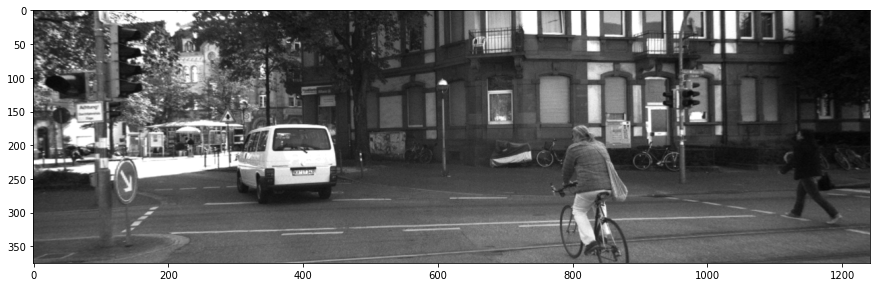

In [110]:
plt.figure(figsize=(15,12))
plt.imshow(test_image1, cmap= "gray")

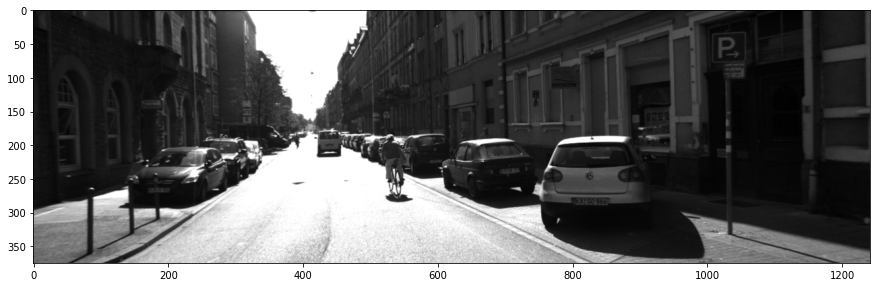

In [118]:
plt.figure(figsize=(15,12))
plt.imshow(test_image2, cmap= "gray")

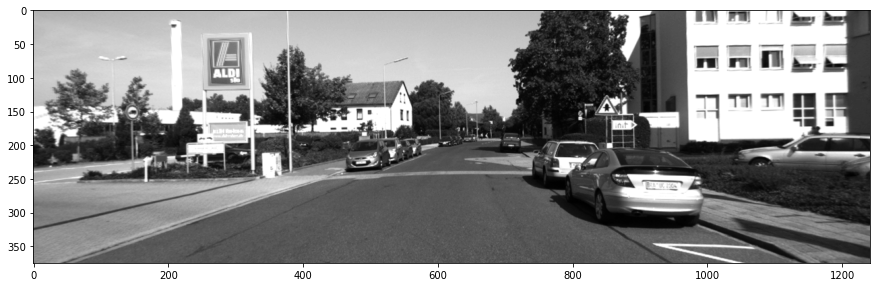

In [119]:
plt.figure(figsize=(15,12))
plt.imshow(test_image3, cmap= "gray")

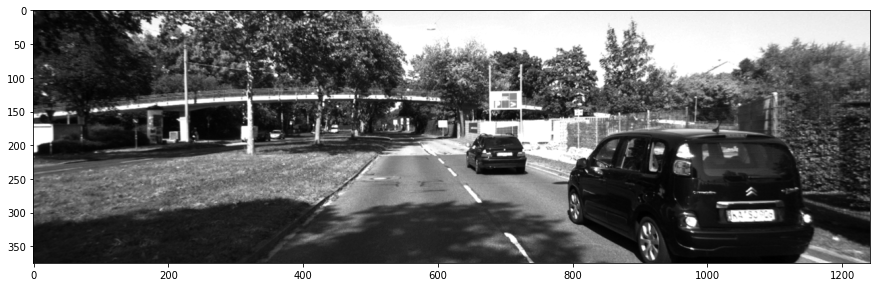

In [120]:
plt.figure(figsize=(15,12))
plt.imshow(test_image4, cmap= "gray")

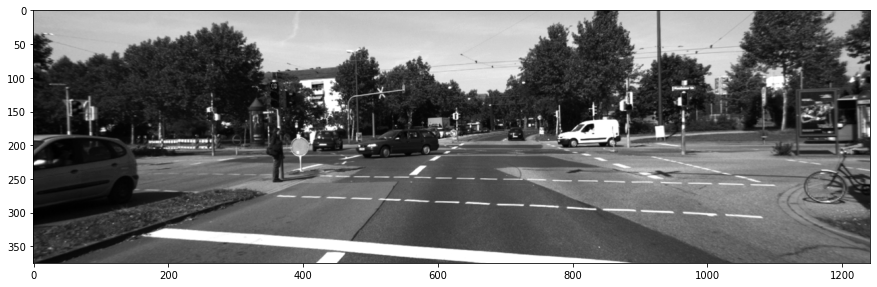

In [123]:
plt.figure(figsize=(15,12))
plt.imshow(test_image5, cmap= "gray")

In [78]:
img_1bb, bb_img1 = vehicle_detector(test_image1, binary_classifiers, bin_rotation_matrix);
img_2bb, bb_img2 = vehicle_detector(test_image2, binary_classifiers, bin_rotation_matrix);
img_3bb, bb_img3 = vehicle_detector(test_image3, binary_classifiers, bin_rotation_matrix);
img_4bb, bb_img4 = vehicle_detector(test_image4, binary_classifiers, bin_rotation_matrix);
img_5bb, bb_img5 = vehicle_detector(test_image5, binary_classifiers, bin_rotation_matrix);

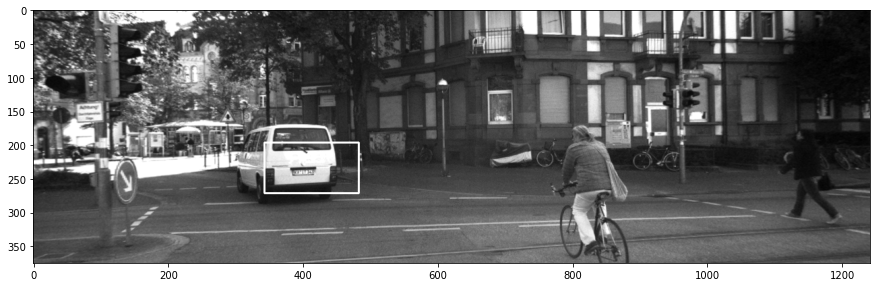

In [115]:
plt.figure(figsize=(15,25));
plt.imshow(img_1bb, cmap= "gray");

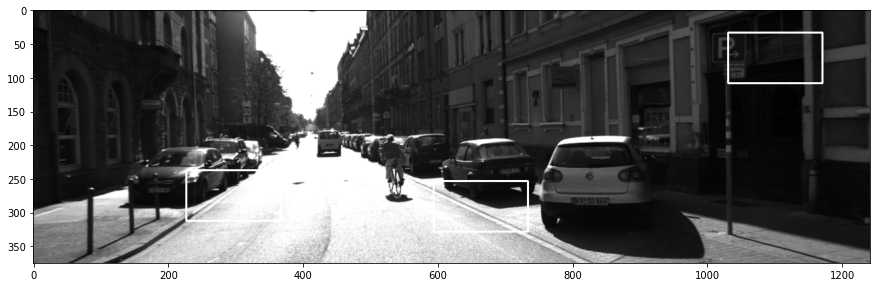

In [126]:
plt.figure(figsize=(15,25));
plt.imshow(img_2bb, cmap= "gray");

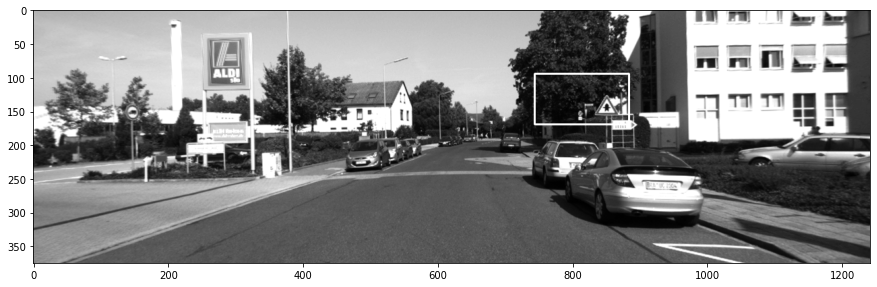

In [127]:
plt.figure(figsize=(15,25));
plt.imshow(img_3bb, cmap= "gray");

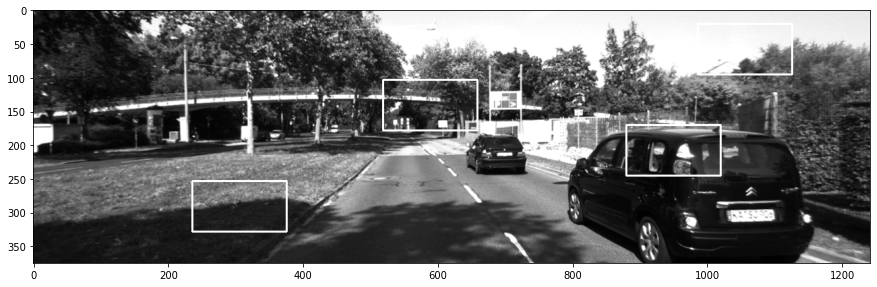

In [128]:
plt.figure(figsize=(15,25));
plt.imshow(img_4bb, cmap= "gray");

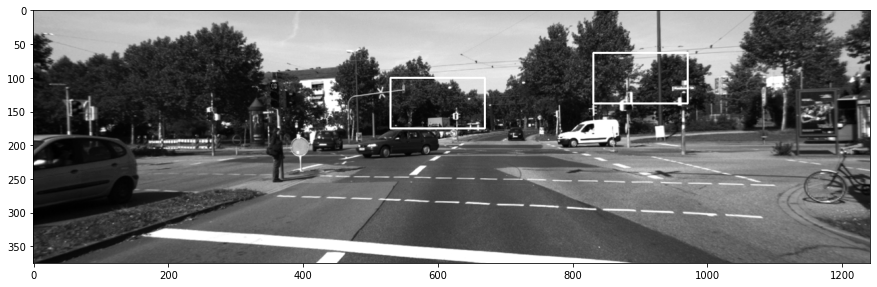

In [129]:
plt.figure(figsize=(15,25));
plt.imshow(img_5bb, cmap= "gray");

In [46]:
# Vehicle detector using the scale space concept
def vehicle_detector_in_scale_space(image, classifiers, rotation_matrix):
    img_size = (85, 85); # h x w in pixels
    cell_size = (6, 6);  # h x w in pixels
    block_size = (6, 6);  # h x w in cells
    nbins = 8;  # number of orientation bins
    hog = cv.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins);
    height, width = image.shape;
    i = 55;
    curr_height = height;
    image_scale_space = [];
    image_scale_space.append(image);
    while(curr_height > 85):
        image_resized = dlib.resize_image(image, height-i, width-i);
        image_scale_space.append(image_resized);
        curr_height = curr_height - 55;
        i += 55;
    located_vehicles = [];
    
    for rescaled_image in image_scale_space:
        height_res, width_res = rescaled_image.shape;
        height_diff = height - height_res;
        width_diff = width - width_res;
        for i in range(0, height_res, 25):
            for j in range(0, width_res, 25):
                window = rescaled_image[i:i+85, j:j+85];
                height, width = window.shape;
                if (height == 85 and width == 85):
                    window_hog_feature = hog.compute(window.reshape(85,85));
                    window_lbp_feature = local_binary_pattern(window, 8, 1, method='uniform').reshape(1, -1);
                    window_whitened = np.matmul(rotation_matrix, window.flatten().reshape(-1,1));
                    window_lbp_feature_wh = local_binary_pattern(window_whitened, 8, 1, method='uniform').reshape(1, -1);
                    window_hog_feature_wh = hog.compute(window_whitened.reshape(85,85).astype(np.uint8));
                    pred_count = 0;
                    for index, classifier in enumerate(classifiers):
                        if (index < 2):
                            pred_count += classifier.predict(window_hog_feature.reshape(1,-1));
                        if (index == 2):
                             pred_count += classifier.predict(window_hog_feature_wh.reshape(1,-1));
                        if (index == 3):
                            pred_count += classifier.predict(window_lbp_feature);
                        if (index == 4):
                            pred_count += classifier.predict(window_lbp_feature_wh);
                    if (pred_count > 4):
                            located_vehicles.append((i + height_diff,j + width_diff));
    rects = [];
    for rect_coord in located_vehicles:
        y, x = rect_coord;
        rect = (x , y, x+140, y +75);
        rects.append(rect);
    min_rect, _ = cv.groupRectangles(rects, 4);
    for bb in min_rect:
        l, t, r, b = bb[0], bb[1], bb[2], bb[3];
        image_bb = cv.rectangle(image, (l,t), (r, b), (255,0,0), 2);
    return image_bb, min_rect;

In [47]:
img_1bb_ss, bb_img1_ss = vehicle_detector_in_scale_space(test_image1, binary_classifiers, bin_rotation_matrix);
img_2bb_ss, bb_img2_ss = vehicle_detector_in_scale_space(test_image2, binary_classifiers, bin_rotation_matrix);
img_3bb_ss, bb_img3_ss = vehicle_detector_in_scale_space(test_image3, binary_classifiers, bin_rotation_matrix);
img_4bb_ss, bb_img4_ss = vehicle_detector_in_scale_space(test_image4, binary_classifiers, bin_rotation_matrix);
img_5bb_ss, bb_img5_ss = vehicle_detector_in_scale_space(test_image5, binary_classifiers, bin_rotation_matrix);

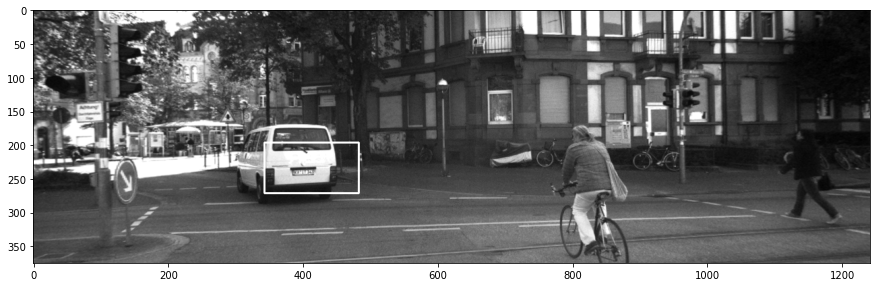

In [48]:
plt.figure(figsize=(15,25));
plt.imshow(img_1bb_ss, cmap= "gray");

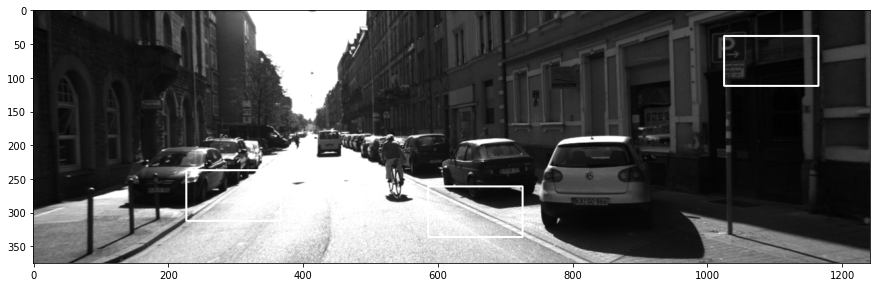

In [49]:
plt.figure(figsize=(15,25));
plt.imshow(img_2bb_ss, cmap= "gray");

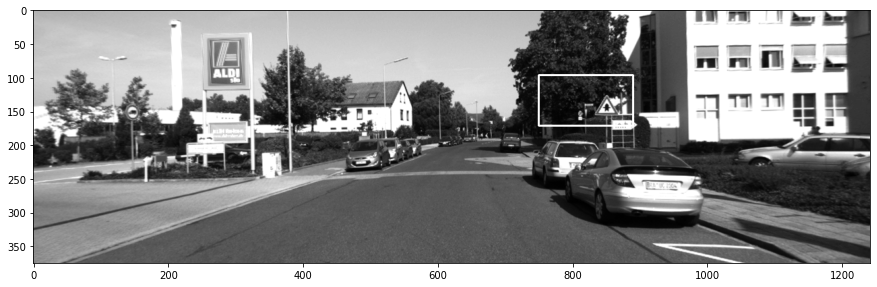

In [50]:
plt.figure(figsize=(15,25));
plt.imshow(img_3bb_ss, cmap= "gray");

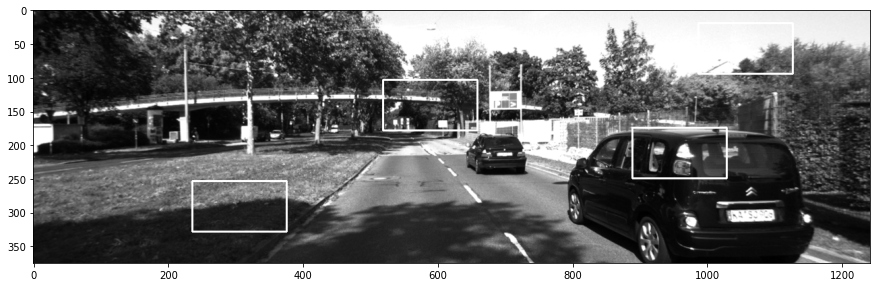

In [51]:
plt.figure(figsize=(15,25));
plt.imshow(img_4bb_ss, cmap= "gray");

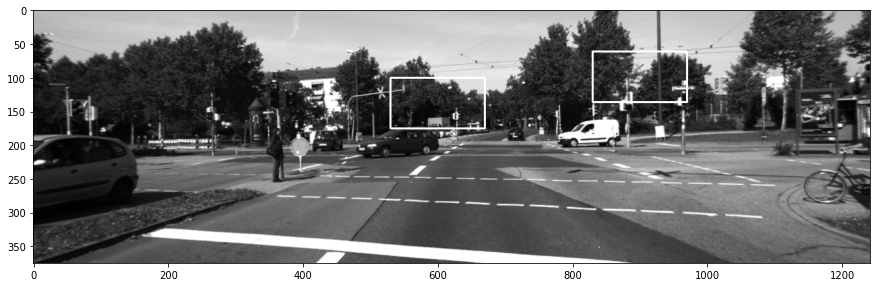

In [52]:
plt.figure(figsize=(15,25));
plt.imshow(img_5bb_ss, cmap= "gray");

In [53]:
#Dataset Augmented with Kaggle dataset
#Source: https://www.kaggle.com/datasets/brsdincer/vehicle-detection-image-set?resource=download
new_path_vehicles = './data/vehicles/';
new_path_non_vehicles = './data/non-vehicles/';

new_dataset_vehicles = [];
for i in range (1, 5970):
    image_path = "{}.png".format(i);
    try:
        img_to_load = dlib.as_grayscale(dlib.load_rgb_image(new_path_vehicles + image_path));
        new_dataset_vehicles.append(img_to_load);
    except:
        continue;
for i in range (1, 835):
    image_path = "far ({}).png".format(i);
    try:
        img_to_load = dlib.as_grayscale(dlib.load_rgb_image(new_path_vehicles + image_path));
        new_dataset_vehicles.append(img_to_load);
    except:
        continue;
for i in range (1, 910):
    image_path = "left ({}).png".format(i);
    try:
        img_to_load = dlib.as_grayscale(dlib.load_rgb_image(new_path_vehicles + image_path));
        new_dataset_vehicles.append(img_to_load);
    except:
        continue;
for i in range (1, 420):
    image_path = "middle ({}).png".format(i);
    try:
        img_to_load = dlib.as_grayscale(dlib.load_rgb_image(new_path_vehicles + image_path));
        new_dataset_vehicles.append(img_to_load);
    except:
        continue;
for i in range (1, 664):
    image_path = "right ({}).png".format(i);
    try:
        img_to_load = dlib.as_grayscale(dlib.load_rgb_image(new_path_vehicles + image_path));
        new_dataset_vehicles.append(img_to_load);
    except:
        continue;

In [54]:
#inclusion of new dataset
new_dataset_non_vehicles = [];
for i in range (1, 5767):
    image_path = "extra{}.png".format(i);
    try:
        img_to_load = dlib.as_grayscale(dlib.load_rgb_image(new_path_non_vehicles + image_path));
        new_dataset_non_vehicles.append(img_to_load);
    except:
        continue;
for i in range (1, 3901):
    image_path = "image{}.png".format(i);
    try:
        img_to_load = dlib.as_grayscale(dlib.load_rgb_image(new_path_non_vehicles + image_path));
        new_dataset_non_vehicles.append(img_to_load);
    except:
        continue;

In [55]:
def rescale_new_dataset(images):
    rescaled_images = [];
    for image in images:
        rescaled_image = dlib.resize_image(image, 85, 85);
        rescaled_images.append(rescaled_image);
    return rescaled_images;

In [56]:
new_vehicles_rescaled = rescale_new_dataset(new_dataset_vehicles);
new_non_vehicles_rescaled = rescale_new_dataset(new_dataset_non_vehicles);

In [57]:
new_vehicles_gs = trucks_gs + vans_gs + cars_gs;
new_non_vehicles_gs = dont_cares_gs + cyclists_gs + pedestrians_gs + miscellaneous_gs + new_non_vehicles_rescaled;
new_images_combined_gs = new_vehicles_gs + new_non_vehicles_gs;

# 1 is vehicle
# 0 is non-vehicle
new_vehicles_labels = [];
new_non_vehicles_labels = [];
for i in range(len(new_vehicles_gs)):
  new_vehicles_labels.append(1)

for j in range(len(new_non_vehicles_gs)):
  new_non_vehicles_labels.append(0)
new_labels_combined = new_vehicles_labels + new_non_vehicles_labels;

In [58]:
new_images_shuffled, new_labels_shuffled = shuffle(new_images_combined_gs, new_labels_combined);

In [59]:
new_hog_feature_gs = [];
for i in range(len(new_images_shuffled)):
    new_hog_feature_gs.append(hog.compute(new_images_shuffled[i].astype(np.uint8)).reshape(1, -1));
new_hog_features_gs = np.vstack(new_hog_feature_gs);

new_lbp_feature_gs = [];
for i in range(len(new_images_shuffled)):
    new_lbp_feature_gs.append(local_binary_pattern(new_images_shuffled[i].astype(np.uint8), 8, 1, method='uniform').reshape(1, -1));
new_lbp_features_gs = np.vstack(new_lbp_feature_gs);

In [60]:
new_clf_rbf_HoG = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
new_clf_rbf_lbp = svm.SVC(gamma='scale',C = 10, kernel='rbf', random_state = 1);
new_clf_forest_hog = RandomForestClassifier(n_estimators=300, max_depth=10, criterion='entropy');
new_clf_forest_lbp = RandomForestClassifier(n_estimators=300, max_depth=10, criterion='entropy');

In [28]:
# RBF SVM Classifier
scoring = ['accuracy','precision','recall'];
scores_svm = cross_validate(new_clf_rbf_HoG, new_hog_features_gs, new_labels_shuffled, scoring=scoring, cv=3);
sorted(scores_svm.keys());
print(scores_svm);

{'fit_time': array([488.29891515, 514.19961381, 545.25068808]), 'score_time': array([515.78370309, 543.44963098, 537.53144789]), 'test_accuracy': array([0.96699552, 0.96950126, 0.9673484 ]), 'test_precision': array([0.9637827 , 0.978738  , 0.96380697]), 'test_recall': array([0.91703893, 0.91123883, 0.91826309])}


In [ ]:
# RBF SVM Classifier
scoring = ['accuracy','precision','recall'];
scores_svm = cross_validate(new_clf_rbf_lbp, new_lbp_features_gs, new_labels_shuffled, scoring=scoring, cv=3);
sorted(scores_svm.keys());
print(scores_svm);

In [ ]:
# Random Forest Classifier
scoring = ['accuracy','precision','recall'];
scores_forest = cross_validate(new_clf_forest_hog, new_hog_features_gs, new_labels_shuffled_wh, scoring=scoring, cv=3);
sorted(scores_forest.keys());
print(scores_forest);

In [ ]:
# Random Forest Classifier
scoring = ['accuracy','precision','recall'];
scores_forest = cross_validate(new_clf_forest_lbp, new_lbp_features_gs, new_labels_shuffled_wh, scoring=scoring, cv=3);
sorted(scores_forest.keys());
print(scores_forest);

In [ ]:
new_clf_rbf_HoG.fit(new_hog_features_gs, new_labels_shuffled);
new_clf_rbf_lbp.fit(new_lbp_features_gs, new_labels_shuffled);
new_clf_forest_hog.fit(new_hog_features_gs, new_labels_shuffled);
new_clf_forest_lbp.fit(new_lbp_features_gs, new_labels_shuffled);

In [ ]:
classifier_v2 = [new_clf_rbf_HoG, new_clf_forest_hog, new_clf_forest_lbp, new_clf_rbf_lbp];

In [ ]:
#Alternate classifier which does not reqiure the whitening preprocessing step
def vehicle_detector_v2(image, classifiers):
    img_size = (85, 85); # h x w in pixels
    cell_size = (6, 6);  # h x w in pixels
    block_size = (6, 6);  # h x w in cells
    nbins = 8;  # number of orientation bins
    hog = cv.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins);
    height, width = image.shape;
    located_vehicles = [];
    for i in range(0, height, 25):
        for j in range(0, width, 25):
            window = image[i:i+85,j:j+85];
            if (window.shape[0] == 85 and window.shape[1] == 85):
                window_hog_feature = hog.compute(window.reshape(85,85));
                window_lbp_feature = local_binary_pattern(window, 8, 1, method='uniform').reshape(1, -1);
                for index, classifier in enumerate(classifiers):
                    if (index < 2):
                        pred_count += classifier.predict(window_hog_feature.reshape(1,-1));
                    else:
                        pred_count += classifier.predict(window_lbp_feature);
                if (pred_count > 3):
                    located_vehicles.append((i,j));
    rects = [];
    print(len(located_vehicles));
    for rect_coord in located_vehicles:
        y, x = rect_coord;
        rect = (x , y, x+140, y +75);
        rects.append(rect);
    min_rect, rect_weights = cv.groupRectangles(rects, 4);
    for bb in min_rect:
        l, t, r, b = bb[0], bb[1], bb[2], bb[3];
        image_bb = cv.rectangle(image, (l,t), (r, b), (255,0,0), 2);
    return image_bb;

In [ ]:
img1_bb_v2 = vehicle_detector_v2(test_image_1, classifiers_v2);
img2_bb_v2 = vehicle_detector_v2(test_image_2, classifiers_v2);
img3_bb_v2 = vehicle_detector_v2(test_image_3, classifiers_v2);
img4_bb_v2 = vehicle_detector_v2(test_image_4, classifiers_v2);
img5_bb_v2 = vehicle_detector_v2(test_image_5, classifiers_v2);

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img1_bb_v2, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img2_bb_v2, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img3_bb_v2, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img4_bb_v2, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img5_bb_v2, cmap= "gray")

In [ ]:
def ground_truth(image, ground_truth_coords):
    l, t, r, b = ground_truth_coords;
    ground_truth = cv.rectangle(image, (l,t), (r, b), (255,0,0), 2);
    return ground_truth;

In [ ]:
img_1_gt = ground_truth(test_image1, patches_s0_IoU[0]);
img_2_gt = ground_truth(test_image2, patches_s0_IoU[134]);
img_3_gt = ground_truth(test_image3, patches_s1_IoU[253]);
img_4_gt = ground_truth(test_image4, patches_s3_IoU[39]);
img_5_gt = ground_truth(test_image5, patches_s2_IoU[135]);

In [ ]:
IoU_test_frame_1 = IoU_calculation(bb_img1, patches_s0_IoU[0]);
IoU_test_frame_2 = IoU_calculation(bb_img2, patches_s0_IoU[134]);
IoU_test_frame_3 = IoU_calculation(bb_img3, patches_s1_IoU[253]);
IoU_test_frame_4 = IoU_calculation(bb_img4, patches_s3_IoU[39]);
IoU_test_frame_4 = IoU_calculation(bb_img5, patches_s2_IoU[135]);

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img_1_gt, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img_2_gt, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img_3_gt, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img_4_gt, cmap= "gray")

In [ ]:
plt.figure(figsize=(15,25))
plt.imshow(img_5_gt, cmap= "gray")

In [ ]:
#Alternate vehicle detector using the scale space concept
def vehicle_detector_v2_scale_space(image, classifiers):
    img_size = (85, 85); # h x w in pixels
    cell_size = (6, 6);  # h x w in pixels
    block_size = (6, 6);  # h x w in cells
    nbins = 8;  # number of orientation bins

    # create HoG Object
    # winSize is the size of the image cropped to multiple of the cell size
    # all arguments should be given in terms of number of pixels
    hog = cv.HOGDescriptor(_winSize=(img_size[1] // cell_size[1] * cell_size[1],
                                  img_size[0] // cell_size[0] * cell_size[0]),
                        _blockSize=(block_size[1] * cell_size[1],
                                    block_size[0] * cell_size[0]),
                        _blockStride=(cell_size[1], cell_size[0]),
                        _cellSize=(cell_size[1], cell_size[0]),
                        _nbins=nbins);
    height, width = image.shape;
    
    i = 55;
    curr_height = height;
    image_scale_space = [];
    image_scale_space.append(image);
    while(curr_height > 85):
        image_resized = dlib.resize_image(image, height-i, width-i);
        image_scale_space.append(image_resized);
        curr_height = curr_height - 55;
        i += 55;
    located_vehicles = [];
    
    for rescaled_image in image_scale_space:
        height_res, width_res = rescaled_image.shape;
        height_diff = height - height_res;
        width_diff = width - width_res;
        for i in range(0, height_res, 25):
            for j in range(0, width_res, 25):
                window = rescaled_image[i:i+85, j:j+85];
                height, width = window.shape;
                if (height == 85 and width == 85):
                    window_hog_feature = hog.compute(window.reshape(85,85));
                    window_lbp_feature = local_binary_pattern(window, 8, 1, method='uniform').reshape(1, -1);
                    for index, classifier in enumerate(classifiers):
                        if (index < 2):
                            pred_count += classifier.predict(window_hog_feature.reshape(1,-1));
                        else:
                            pred_count += classifier.predict(window_lbp_feature);
                    if (pred_count > 3):
                        located_vehicles.append((i+height_diff,j+width_diff));
    rects = [];
    print(len(located_vehicles));
    for rect_coord in located_vehicles:
        y, x = rect_coord;
        rect = (x , y, x+140, y +75);
        rects.append(rect);
    min_rect, rect_weights = cv.groupRectangles(rects, 4);
    for bb in min_rect:
        l, t, r, b = bb[0], bb[1], bb[2], bb[3];
        image_bb = cv.rectangle(image, (l,t), (r, b), (255,0,0), 2);
    return image_bb, min_rect;

In [ ]:
img1_bb_v2_ss, bb_img1_v2_ss = vehicle_detector_v2_scale_space(test_image_1, classifiers_v2);
img2_bb_v2_ss, bb_img2_v2_ss = vehicle_detector_v2_scale_space(test_image_2, classifiers_v2);
img3_bb_v2_ss, bb_img3_v2_ss = vehicle_detector_v2_scale_space(test_image_3, classifiers_v2);
img4_bb_v2_ss, bb_img4_v2_ss = vehicle_detector_v2_scale_space(test_image_4, classifiers_v2);
img5_bb_v2_ss, bb_img5_v2_ss = vehicle_detector_v2_scale_space(test_image_5, classifiers_v2);

In [ ]:
def ground_truth(image, ground_truth_coords):
    l, t, r, b = ground_truth_coords;
    ground_truth = cv.rectangle(image, (l,t), (r, b), (255,0,0), 2);
    return ground_truth;

In [72]:
#Input Parameters: Detections from the vehicle detector, ground truth labels for the associated frame
def IoU_calculation(set_of_detections, ground_truth_patches):
    IoUs = [];
    for detection in set_of_detections:
        l, t, r, b = detection;
        det_area = (r-l)*(b-t)
        for patch in ground_truth_patches:
            p_l, p_t, p_r, p_b = patch;
            left_point = max(float(p_l), float(l));
            right_point = min(float(p_r), float(r));
            top_point = max(float(t), float(p_t));
            bottom_point = min(float(b), float(p_b));
            if (left_point > right_point or top_point > bottom_point):
                continue;
            else:
                area_of_intersect = (left_point - right_point) * (bottom_point - top_point);
                patch_area = (float(p_r) - float(p_l)) * (float(p_b) - float(p_t));
                IoU = abs(area_of_intersect / ((patch_area + det_area) - area_of_intersect));
                IoUs.append(IoU);
    return IoU;

In [90]:
#Input Parameters: path of each sequence, path where the patches should be stored, dictionary of the patches
#Extracts the patches and saves them in the respective frame directory.
def detections_for_IoU(image_dir, patches_IoU, patch_dict, classifiers, rotation_matrix):
    average_IoU = []
    for frame_num in range(len(patch_dict)):
        patch_list = patch_dict[frame_num];
        if (frame_num < 10):
            img_path = image_dir + '00000{}.png'.format(frame_num);
        if (frame_num > 9 and frame_num < 100):
            img_path = image_dir + '0000{}.png'.format(frame_num);
        if (frame_num > 99):
            img_path = image_dir + '000{}.png'.format(frame_num);
        sequence_img = dlib.as_grayscale(dlib.load_rgb_image(img_path));
        try: 
            bb_image, detections = vehicle_detector(sequence_img, classifiers, rotation_matrix);
            IoU = IoU_calculation(bb_image, patches_IoU);
            average_IoU += IoU;
        except:
            continue;
    return average_IoU / len(patch_dict) ;

In [ ]:
IoU_Seq0 = detections_for_IoU(s0, patches_s0_IoU, patches_s0, binary_classifiers, bin_rotation_matrix);
IoU_Seq1 = detections_for_IoU(s1, patches_s1_IoU, patches_s1, binary_classifiers, bin_rotation_matrix);
IoU_Seq2 = detections_for_IoU(s2, patches_s2_IoU, patches_s2, binary_classifiers, bin_rotation_matrix);
IoU_Seq3 = detections_for_IoU(s3, patches_s3_IoU, patches_s3, binary_classifiers, bin_rotation_matrix);